In [2]:
base_folder = '/content/drive/MyDrive/Bioinfo/EXAM/LAB10'

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Assignment 1

## Dataset

### Methylation

In [115]:
meth_path = base_folder + '/meth.txt'
X = []
with open(meth_path, 'r') as f:
  # Drop header
  _ = f.readline()

  for line in f:
    fields = line.split()[1:]
    X.append(list(map(lambda x: float(x), fields)))

X_meth = np.transpose(X).astype(dtype='float32')

### mRNA

In [66]:
mrna_path = base_folder + '/mRNA.txt'
X = []
with open(mrna_path, 'r') as f:
  # Drop header
  _ = f.readline()

  for line in f:
    fields = line.split()[1:]
    X.append(list(map(lambda x: float(x), fields)))

X_rna = np.transpose(X).astype(dtype='float32')

In [67]:
labels_path = base_folder + '/clusters.txt'
y = []
with open(labels_path, 'r') as f:
  # Drop header
  _ = f.readline()

  for line in f:
    y.append(int(line.split()[-1]))

y = np.array(y)

In [68]:
X_train_rna, X_test_rna, y_train, y_test = train_test_split(X_rna, y, test_size = 0.2, random_state = 42)

In [116]:
X_train_meth, X_test_meth, _, _ = train_test_split(X_meth, y, test_size = 0.2, random_state = 42)

## SMOTE

In [78]:
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train_rna, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [79]:
print(f"Labels frequency before SMOTE: {Counter(y_train)}")
print(f"Labels frequency after SMOTE: {Counter(y_train_res)}")

Labels frequency before SMOTE: Counter({1: 1007, 3: 800, 2: 796, 4: 788, 5: 609})
Labels frequency after SMOTE: Counter({3: 1007, 1: 1007, 4: 1007, 5: 1007, 2: 1007})


In [80]:
# Count the number of new samples added by SMOTE

label_counter = Counter(y_train)
label_counter_res = Counter(y_train_res)

number_new_samples = 0
new_samples_per_label = dict()
for key in label_counter:
  value = label_counter[key]
  value_res = label_counter_res[key]

  resampling_size = value_res - value
  number_new_samples += resampling_size
  new_samples_per_label[int(key)] = resampling_size

print(f"Total number of synthetic SMOTE samples: {number_new_samples}")
print(f"Number of synthetic SMOTE samples per label:{new_samples_per_label}")

Total number of synthetic SMOTE samples: 1035
Number of synthetic SMOTE samples per label:{3: 207, 1: 0, 4: 219, 5: 398, 2: 211}


In [81]:
# SMOTE samples
synth_samples = X_train_res[-number_new_samples:]
synth_labels = y_train_res[-number_new_samples:]

smote_samples = dict()
for i in range(1, 6):
  mask = np.array(synth_labels == i)
  smote_samples[i] = synth_samples[mask]

## GAN
One gan for each class

In [10]:
target_shape = X.shape[1]

In [83]:
LATENT_DIM = 64
EPOCHS = 15
BATCH_SIZE = 32

In [12]:
inputs = keras.layers.Input(shape=(target_shape, ))
x = keras.layers.Dense(128)(inputs)
x = keras.layers.Reshape((128, 1))(x)
x = keras.layers.Conv1D(16, 2, 2, activation='relu', padding='same')(x)
x = keras.layers.Conv1D(256, 2, 2, activation='relu', padding='same')(x)
x = keras.layers.Conv1D(512, 2, 2, activation='relu', padding='same')(x)

x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(1)(x)

discriminator = keras.Model(inputs, outputs)

discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 131)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               16896     
_________________________________________________________________
reshape (Reshape)            (None, 128, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 64, 16)            48        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 256)           8448      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 512)           262656    
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0     

In [13]:
inputs = keras.layers.Input(shape=(LATENT_DIM, ))
x = keras.layers.Reshape((LATENT_DIM, 1))(inputs)
x = keras.layers.Conv1DTranspose(filters=512,
                                 kernel_size=1,
                                 strides=1,
                                 activation='relu',
                                 padding='same')(x)
x = keras.layers.Conv1DTranspose(filters=256,
                                 kernel_size=2,
                                 strides=2,
                                 activation='relu',
                                 padding='same')(x)
x = keras.layers.Conv1DTranspose(filters=16,
                                 kernel_size=2,
                                 strides=2,
                                 activation='relu',
                                 padding='same')(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(target_shape)(x)

generator = keras.Model(inputs, outputs)

generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 1)             0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 64, 512)           1024      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 128, 256)          262400    
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 256, 16)           8208      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 131)               5367

In [61]:
class GAN(keras.Model):
  
  def __init__(self, generator, discriminator, latent_dim):
    super(GAN, self).__init__()
    self.generator = generator
    self.discriminator = discriminator
    self.latent_dim = latent_dim


  def compile(self, d_optim, g_optim, loss):
    super(GAN, self).compile()
    self.d_optim = d_optim
    self.g_optim = g_optim
    self.loss_fn = loss


  def train_step(self, data):
    if isinstance(data, tuple):
      data = data[0]
    batch_size = tf.shape(data)[0]
    
    # Sample from latent space
    z = tf.random.normal((batch_size, self.latent_dim))
    fake_imgs = self.generator(z)

    # Concatenate fake and real images and define the labels
    images = tf.concat([data, fake_imgs], axis=0)
    labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    

    # Train discriminator
    with tf.GradientTape() as tape:
      preds = self.discriminator(images)
      d_loss = self.loss_fn(labels, preds)

    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    
    # Train generator
    z = tf.random.normal((batch_size, self.latent_dim))

    # Misleading labels: label everything as real
    misleading_labels = tf.zeros((batch_size, 1))

    with tf.GradientTape() as tape:
      fake_imgs = self.generator(z)
      preds = self.discriminator(fake_imgs)
      g_loss = self.loss_fn(misleading_labels, preds)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

    return {'d_loss': d_loss, 'g_loss': g_loss}

In [82]:
# Create a GAN model for each label

gan_models = dict()
for i in range(1, 6):
  mask = np.array(y_train == i)

  train_dataset = X_train_rna[mask]

  # Passing  a clone, since pass by reference would update discriminator and generator
  gan = GAN(keras.models.clone_model(generator), keras.models.clone_model(discriminator), LATENT_DIM)
  gan.compile(keras.optimizers.Adam(), keras.optimizers.Adam(),
              keras.losses.BinaryCrossentropy(from_logits = True))
  
  history = gan.fit(train_dataset, epochs = 30, batch_size = 32)
  gan_models[i] = gan

Epoch 1/30
32/32 [==============================] - 2s 8ms/step - d_loss: 0.5083 - g_loss: 1.0673
Epoch 2/30
32/32 [==============================] - 0s 8ms/step - d_loss: 0.2996 - g_loss: 2.6926
Epoch 3/30
32/32 [==============================] - 0s 8ms/step - d_loss: 1.2043 - g_loss: 7.5171
Epoch 4/30
32/32 [==============================] - 0s 8ms/step - d_loss: 0.5611 - g_loss: 1.7824
Epoch 5/30
32/32 [==============================] - 0s 8ms/step - d_loss: 0.7699 - g_loss: 1.3145
Epoch 6/30


KeyboardInterrupt: ignored

In [63]:
# Store gan samples separated by label

gan_samples = dict()
for key, model in gan_models.items():
  num_imgs = new_samples_per_label[key]
  random_latent_vectors = tf.random.normal(shape=(num_imgs, LATENT_DIM))
  generated_sequences = model.generator(random_latent_vectors)
  generated_sequences = generated_sequences.numpy()

  gan_samples[key] = generated_sequences

In [59]:
def plot_data(data, fig, ax, label):
  color = ['tab:orange', 'tab:blue', 'tab:green']

  test, gan, smote = data
  i = label - 1

  ax[i].scatter(test[0], test[1], c = color[0], s = 13, label = 'test')

  try:
    ax[i].scatter(smote[0], smote[1], c = color[2], s = 13, label = 'smote')
    ax[i].scatter(gan[0], gan[1], c = color[1], s = 13, label = 'gan')
  except:
    pass

  ax[i].set_title(f"Data points for label {label}")
  ax[i].set_xlabel('PC1', fontsize = 13)
  ax[i].set_ylabel('PC2', fontsize = 13)

  ax[i].legend()

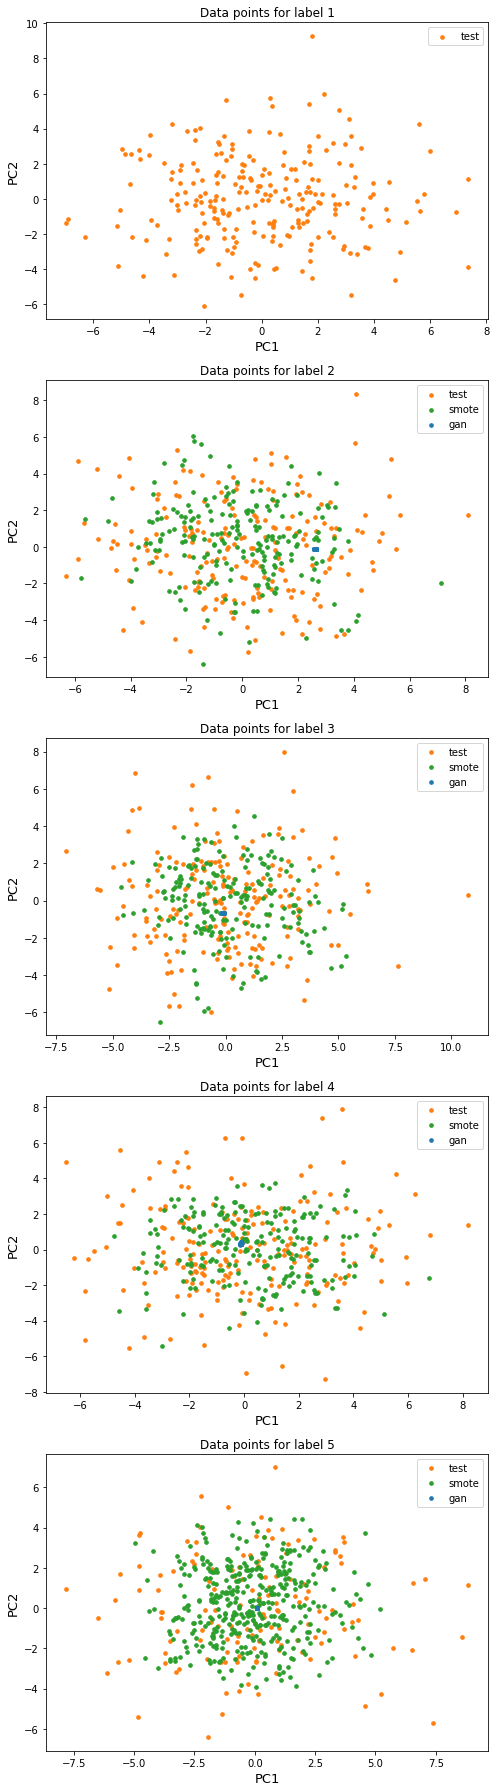

In [64]:
labels = range(1, 6)
fig, ax = plt.subplots(nrows = len(labels), figsize = (7, 25))

for lab in labels:
  mask = y_test == lab
  pca = PCA(n_components = 2, random_state = 42)
  X_test_pca = pca.fit_transform(X_test[mask])

  try:
    X_gan_pca = pca.transform(gan_samples[lab])
  except:
    X_gan_pca = np.array([[], []])

  try:
    X_smote_pca = pca.transform(smote_samples[lab])
  except:
    X_smote_pca = np.array([[], []])

  pca_data = X_test_pca.transpose(), X_gan_pca.transpose(), X_smote_pca.transpose()
  plot_data(pca_data, fig, ax, lab)

plt.tight_layout()
plt.show()

# Assignment 2

## mRNA: Encoder, Decoder


In [84]:
# Implement reparametrization trick

class Sampling(keras.layers.Layer):
  
  def call(self, params):
    mean, var = params
    batch_size = tf.shape(mean)[0]
    latent_dim = tf.shape(mean)[1]
    epsilon = tf.random.normal(shape = (batch_size, latent_dim))

    normal_samples = mean + tf.exp(0.5 * var) * epsilon

    return normal_samples

In [86]:
rna_num_features = X_rna.shape[1]

inputs = keras.layers.Input(shape=(rna_num_features, 1))
x = keras.layers.Conv1D(8, 2, 2, activation='relu')(inputs)
x = keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation = "relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.BatchNormalization()(x)
z_mean = keras.layers.Dense(LATENT_DIM, name = "z_mean")(x)
z_var = keras.layers.Dense(LATENT_DIM, name = "z_var")(x)
z_samples = Sampling()([z_mean, z_var])

rna_encoder = keras.Model(inputs, [z_mean, z_var, z_samples], name = "rna_encoder")
rna_encoder.summary()

Model: "rna_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 131, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 65, 8)        24          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 65, 8)        0           conv1d_3[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 520)          0           max_pooling1d[0][0]              
________________________________________________________________________________________

In [87]:
decoder_in_shape = rna_encoder.output_shape[1][1]

inputs = keras.layers.Input((decoder_in_shape, ))
x = keras.layers.Reshape((LATENT_DIM, 1))(inputs)
x = keras.layers.Conv1DTranspose(8, 1, 1, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(rna_num_features, activation = 'relu')(x)

rna_decoder = keras.Model(inputs, outputs, name = 'rna_decoder')
rna_decoder.summary()

Model: "rna_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 64, 1)             0         
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 64, 8)             16        
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 8)             32        
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                16416     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                

## Meth: Encoder, Decoder

In [117]:
meth_num_features = X_meth.shape[1]

inputs = keras.layers.Input(shape=(meth_num_features, 1))
x = keras.layers.Conv1D(8, 2, 2, activation='relu')(inputs)
x = keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
x = keras.layers.Conv1D(16, 2, 2, activation='relu')(inputs)
x = keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
x = keras.layers.Conv1D(64, 2, 2, activation='relu')(inputs)
x = keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation = "relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.BatchNormalization()(x)
z_mean = keras.layers.Dense(LATENT_DIM, name = "z_mean")(x)
z_var = keras.layers.Dense(LATENT_DIM, name = "z_var")(x)
z_samples = Sampling()([z_mean, z_var])

meth_encoder = keras.Model(inputs, [z_mean, z_var, z_samples], name = "meth_encoder")
meth_encoder.summary()

Model: "meth_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 367, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 183, 64)      192         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 183, 64)      0           conv1d_9[0][0]                   
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 11712)        0           max_pooling1d_6[0][0]            
_______________________________________________________________________________________

In [118]:
decoder_in_shape = meth_encoder.output_shape[1][1]

inputs = keras.layers.Input((decoder_in_shape, ))
x = keras.layers.Reshape((LATENT_DIM, 1))(inputs)
x = keras.layers.Conv1DTranspose(8, 1, 1, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(meth_num_features, activation = 'relu')(x)

meth_decoder = keras.Model(inputs, outputs, name = 'meth_decoder')
meth_decoder.summary()

Model: "meth_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 64, 1)             0         
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 64, 8)             16        
_________________________________________________________________
batch_normalization_14 (Batc (None, 64, 8)             32        
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                16416     
_________________________________________________________________
batch_normalization_15 (Batc (None, 32)               

## VAE

1D VAE for domain transfer

In [108]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, beta=0.017):
    super(VAE, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.beta = beta


  def call(self, x):
    z_mean, z_var, encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return z_mean, z_var, decoded

  
  def train_step(self, data):
    x = data
    y = data

    with tf.GradientTape() as tape:
      z_mean, z_log_var, decoded = self(x)
      reconstruction_loss = tf.reduce_sum(
                    keras.losses.mean_squared_error(y, decoded), axis=0
                  )
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss))
      total_loss = reconstruction_loss + kl_loss*self.beta
    
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {"kl_loss": kl_loss, "reconstruction_loss": reconstruction_loss}

### RNA Train

In [112]:
rna_vae = VAE(keras.models.clone_model(rna_encoder),
          keras.models.clone_model(rna_decoder))
rna_vae.compile(optimizer = tf.keras.optimizers.Adam(1e-3))
rna_vae.fit(X_train_rna, epochs=5, batch_size = BATCH_SIZE)

Epoch 1/5
125/125 [==============================] - 2s 4ms/step - kl_loss: 19.6489 - reconstruction_loss: 79.3484
Epoch 2/5
125/125 [==============================] - 1s 4ms/step - kl_loss: 0.1802 - reconstruction_loss: 68.3257
Epoch 3/5
125/125 [==============================] - 1s 4ms/step - kl_loss: 0.1305 - reconstruction_loss: 68.1726
Epoch 4/5
125/125 [==============================] - 1s 4ms/step - kl_loss: 0.0968 - reconstruction_loss: 68.0156
Epoch 5/5
125/125 [==============================] - 1s 4ms/step - kl_loss: 0.0638 - reconstruction_loss: 67.9109


### Meth Train

In [119]:
meth_vae = VAE(keras.models.clone_model(meth_encoder),
          keras.models.clone_model(meth_decoder))
meth_vae.compile(optimizer = tf.keras.optimizers.Adam(1e-3))
meth_vae.fit(X_train_meth, epochs=5, batch_size = BATCH_SIZE)

Epoch 1/5
125/125 [==============================] - 2s 4ms/step - kl_loss: 0.2717 - reconstruction_loss: 1.5472
Epoch 2/5
125/125 [==============================] - 1s 4ms/step - kl_loss: 0.0012 - reconstruction_loss: 1.1956
Epoch 3/5
125/125 [==============================] - 1s 4ms/step - kl_loss: 3.7528e-04 - reconstruction_loss: 1.1817
Epoch 4/5
125/125 [==============================] - 1s 4ms/step - kl_loss: 1.4484e-04 - reconstruction_loss: 1.1768
Epoch 5/5
125/125 [==============================] - 1s 4ms/step - kl_loss: 7.0087e-05 - reconstruction_loss: 1.1725


### Domain Translation: Meth to mRNA
Use test data of methylation to create latent space, and from that latent space generate synthetic mRNA data

In [127]:
# Store rna domain-transfer (dt) samples separated by label

dt_rna_samples = dict()
labels = range(1, 6)
for lab in labels:
  mask = y_test == lab
  test_data = X_test_meth[mask]
  _, _, encoded = meth_vae.encoder(test_data)
  decoded = rna_vae.decoder(encoded)
  dt_rna_samples[lab] = decoded

In [128]:
def plot_data(data, fig, ax, label, source_names):
  color = ['tab:blue', 'tab:green', 'tab:purple', 'tab:red']
  i = label - 1

  for c, source in enumerate(data):
    source_name= source_names[c]

    try:
      ax[i].scatter(source[0], source[1], c = color[c], s = 13, label = source_name)
    except:
      pass

  ax[i].set_title(f"Data points for label {label}")
  ax[i].set_xlabel('PC1', fontsize = 13)
  ax[i].set_ylabel('PC2', fontsize = 13)

  ax[i].legend()

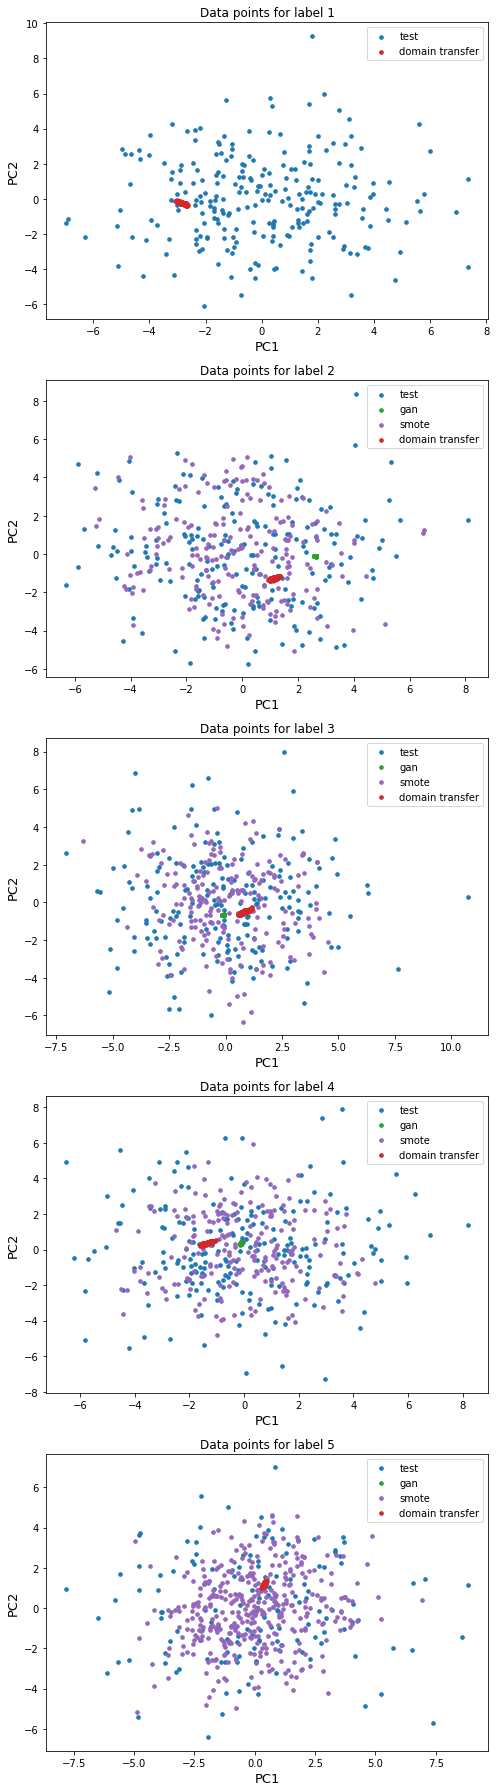

In [130]:
labels = range(1, 6)
fig, ax = plt.subplots(nrows = len(labels), figsize = (7, 25))
source_names = ['test', 'gan', 'smote', 'domain transfer']

for lab in labels:
  mask = y_test == lab
  pca = PCA(n_components = 2, random_state = 42)
  X_test_pca = pca.fit_transform(X_test_rna[mask])

  try:
    X_gan_pca = pca.transform(gan_samples[lab])
  except:
    X_gan_pca = np.array([[], []])

  try:
    X_smote_pca = pca.transform(smote_samples[lab])
  except:
    X_smote_pca = np.array([[], []])

  X_dt_pca = pca.transform(dt_rna_samples[lab])

  pca_data = X_test_pca.transpose(), X_gan_pca.transpose(),\
   X_smote_pca.transpose(), X_dt_pca.transpose()

  plot_data(pca_data, fig, ax, lab, source_names)

plt.tight_layout()
plt.show()